In this dataset ('spiketrain.txt') 

https://s-shinomoto.com/CONNECT/

https://github.com/shigerushinomoto/CoNNECT

- The inhibitory connection width is much larger going of the order of 10 ms, so **width check** for significance was increased
- **sig_width = [0.0008, 0.08]; sig_width_inh = [0.0012, 0.08]**

**Overall, 2 mismatched E-E connections, I-E connections that I would consider valid 

In [1]:
import tqdm, os
import pandas as pd
import numpy as np
from ccgutils import *
import scipy.io as spio
import pynapple as nap
import matplotlib.pyplot as plt

In [2]:
# general params
bin_dur = 0.0004 # 0.4 ms
win_dur = 0.05 # 50 ms
alpha = 0.001 # p-val for peak
deconvolve = False

# jitter params
jitterMax = 0.005 # 5 ms [+/- 5ms seconds] Schwindel et al. 
shufJitterIter = 1000 # shuffle 1000times

# convolution params
convType = 'median' # convolution type: gaussian or median
W = int(0.01/bin_dur) # 10 ms

# significance calculation
min_win_monosyn = 0.0008 # 0.8ms
win_monosyn = 0.008 # right edge of window to look for mono-synaptic connection
alpha2 = 0.01 # p-val threshold for peak or dip width
# width should be above alpha2 in (0.8 - 4ms) range; 5-0.8 = 4.2ms
sig_width = [0.0008, 0.008]
sig_width_inh = [0.0008, 0.008]
# zero-bins range : (-0.4 to 0.4) ms
zero_bins = [-0.0006, 0.0006] #ms
# peaksd, widthsd
peaksd = 2.5
dipsd = 2
widthsd = 1
# threshold for atleast few spikes
spkTh = 25

In [3]:
def load_spiketimes(file_path):
    spiketimes = []
    neuron_ids = []
    neuron_id = 1
    with open(file_path, 'r') as file:
        for line in file:
            if ';' in line:
                neuron_id += 1
            timestamps = [float(t) for t in line.strip().rstrip(';').split() if t]
            spiketimes.extend(timestamps)
            neuron_ids.extend([neuron_id] * len(timestamps))

    spktimes = np.array(spiketimes) / 1000.0  # Convert to seconds
    cluid = np.array(neuron_ids)

    valid_indices = spktimes > 0
    return spktimes[valid_indices], cluid[valid_indices]

# Usage
file_path = 'spiketrain-connect.txt'
spktimes, cluid = load_spiketimes(file_path)
print(len(spktimes) == len(cluid))

connect = np.loadtxt('estimated-connect.csv', delimiter=',')#, index_col=False, index_row=False)
connect[connect>0] = 1
connect[connect<0] = -1
connect = connect.T

True


## Compute and plot CCG for each in +/- 30 ms window

In [4]:
# compute N spikes for each unit
cluid_ = np.unique(cluid)
nCells = len(cluid_) 
Nspk = np.zeros_like(cluid_, dtype='int')
# Loop through each unique value in Gsub and count occurrences in spkL
for c,cid in enumerate(cluid_):
    Nspk[c] = np.sum(cluid==cid)

In [5]:
# compute CCG
cch, t = CCG(spktimes, cluid, binSize=bin_dur, duration=win_dur, alpha=alpha)

# reshape and calculate auto-correlogram
if deconvolve:
    cch, ach1, nspks1, ach2, nspks2 = CCH3D_reshape(cch, Nspk)
    # deconvoluted cross-correlogram
    cch = cchdeconv(cch, ach1, nspks1, ach2, nspks2)
    # reshape for easier plotting
    cch = np.reshape(cch, [cch.shape[0],nCells,nCells])
cch = np.reshape(cch, [cch.shape[0],nCells,nCells])

# unique pairs (so we can work in both forward and backward direction)
cc_pairs = np.tril_indices(cch.shape[1], k=-1)
cc_pairs = np.column_stack(cc_pairs)
cc_pairs.shape

(1225, 2)

## Convolution and significance

In [6]:
# o/p variables 
Pval = np.full([len(t), nCells, nCells], np.nan)
Pred = np.full([len(t), nCells, nCells], np.nan)
Bounds = np.full([cch.shape[0], nCells, nCells, 2], np.nan)
Pcausal_exc = np.zeros([nCells, nCells])
Pcausal_inh = np.zeros([nCells, nCells])
syn_strength_exc = np.full([nCells, nCells], np.nan)
syn_ratio_exc = np.full([nCells, nCells], np.nan)
syn_strength_inh = np.full((nCells, nCells), np.nan)
syn_ratio_inh = np.full((nCells, nCells), np.nan)
sig_con_exc = []
sig_con_inh = []

# post and pre bins to mess with
# some sig. digit shit to deal with
postbins = (t>=min_win_monosyn) & (t<=win_monosyn+bin_dur/2)
prebins = (t<=-min_win_monosyn) & (t>=-win_monosyn-bin_dur/2)
zero_lag_bins = (t>=zero_bins[0]-bin_dur/2) & (t<=zero_bins[1]+bin_dur/2)

# go through each pair 
for refcid in range(nCells):
    for targetcid in range(refcid+1, nCells):
        # ccg for respective connection
        ccg = cch[:, refcid, targetcid]

        # calculate null-distribution using convolution based 
        # on Stark & Abeles; poisson continuity correction
        pvals, pred, qvals = cch_conv(ccg, W, WINTYPE=convType)
        pvals, pred, qvals = np.ravel(pvals), np.ravel(pred), np.ravel(qvals)
        # Store predicted values and pvalues for subsequent plotting
        Pred[:, refcid, targetcid] = pred
        Pval[:, refcid, targetcid] = pvals
        Pred[:, targetcid, refcid] = np.flipud(pred)
        Pval[:, targetcid, refcid] = np.flipud(pvals)
        
        # calculate upper and lower bound with bonferroni correction, given alpha levels
        hiBound, loBound = calculate_bounds(pred, alpha, np.ceil(win_monosyn/bin_dur)*2)
        Bounds[:, refcid, targetcid, 0] = hiBound
        Bounds[:, refcid, targetcid, 1] = loBound
        Bounds[:, targetcid, refcid, 0] = np.flipud(hiBound)
        Bounds[:, targetcid, refcid, 1] = np.flipud(loBound)

        # get baseline ccg and std
        baseline_ccg = ccg - pred
        std_baseline = np.nanstd(baseline_ccg)

        ########## EXCITATORY checks for both sides ref -> target (post), target -> ref (pre)
        sig = ccg > hiBound
        
        # check all condition
        # peak pval < 0.001, peak > 2.5 sd, in [0.8 - 4.8]ms
        # width pval < 0.01, width > 1 sd or 1/2*height of peak
        # no zero lag peaks (common input)
        post_exc_check, pre_exc_check = check_exc_conn(ccg, hiBound, loBound, pred, pvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur,
                                                       alpha=alpha, alpha2=alpha2, sig_width=sig_width, peaksd=peaksd, widthsd=widthsd)
        
        # store o/p
        if post_exc_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[postbins]
            bccg[bccg<0] = 0
            syn_strength_exc[refcid,targetcid] = np.nansum(bccg)/Nspk[refcid]
            # peak/baseline ratio
            syn_ratio_exc[refcid, targetcid] = np.nanmax(ccg[postbins])/np.nanmean(pred[postbins])
            sig_con_exc.append([refcid, targetcid])
            Pcausal_exc[refcid, targetcid] = 1

        if pre_exc_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[prebins]
            bccg[bccg<0] = 0
            syn_strength_exc[targetcid, refcid] = np.nansum(bccg)/Nspk[targetcid]
            # peak/baseline ratio
            syn_ratio_exc[targetcid, refcid] = np.nanmax(ccg[prebins])/np.nanmean(pred[prebins])
            sig_con_exc.append([targetcid, refcid])
            Pcausal_exc[targetcid, refcid] = 1

        #print(refcid, targetcid, post_exc_check, pre_exc_check)

        ######### INHIBITORY connections checks again for both directions
        post_inh_check, pre_inh_check = check_inh_conn(ccg, hiBound, loBound, pred, qvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur, 
                                                       alpha=alpha, alpha2=alpha2, sig_width=sig_width_inh, dipsd=dipsd, widthsd=widthsd)
        
        # store o/p
        if post_inh_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[postbins]
            bccg[bccg>0] = 0
            syn_strength_inh[refcid,targetcid] = np.abs(np.nansum(bccg))/Nspk[refcid]
            # valley/baseline ratio
            syn_ratio_inh[refcid, targetcid] = np.abs(np.nanmin(ccg[postbins])/np.nanmean(pred[postbins]))
            sig_con_inh.append([refcid, targetcid])
            Pcausal_inh[refcid, targetcid] = -1

        if pre_inh_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[prebins]
            bccg[bccg>0] = 0
            syn_strength_inh[targetcid, refcid] = np.abs(np.nansum(bccg)/Nspk[targetcid])
            # valley/baseline ratio
            syn_ratio_inh[targetcid, refcid] = np.abs(np.nanmin(ccg[prebins])/np.nanmean(pred[prebins]))
            sig_con_inh.append([targetcid, refcid])
            Pcausal_inh[targetcid, refcid] = -1
            
        #print(refcid, targetcid, post_inh_check, pre_inh_check)

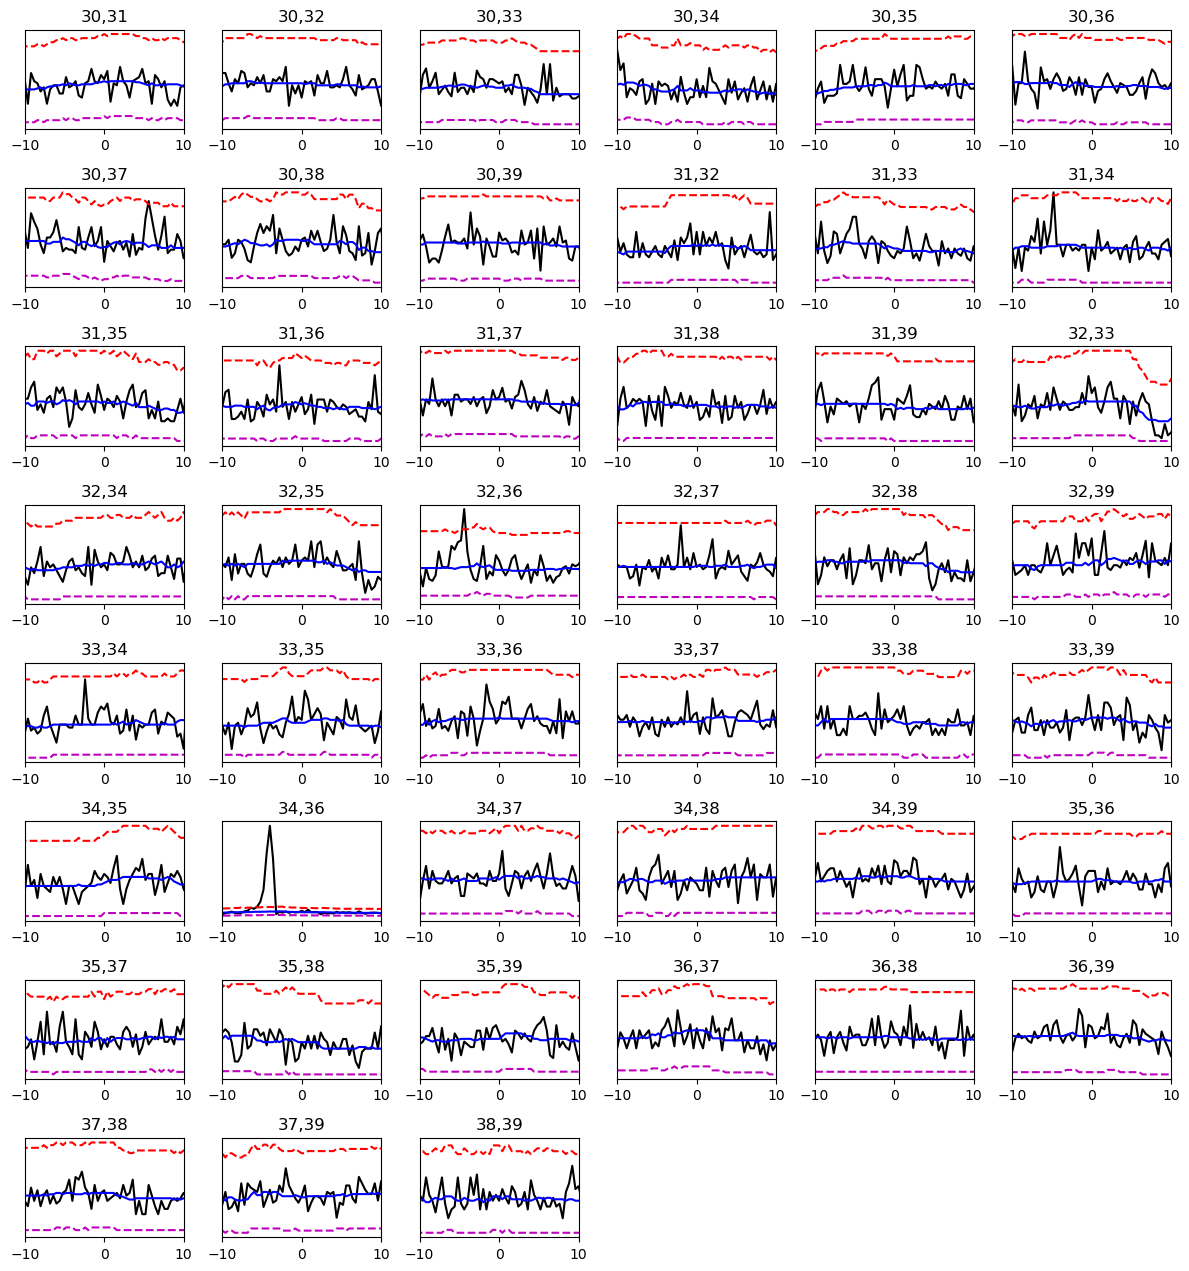

In [7]:
# plot CCG with significance bounds
count = 1 
plt.figure(figsize=(12,30))
for refcid in range(30,40):
    for targetcid in range(refcid+1,40):
        plt.subplot(19,6,count)
        plt.plot(t*1000, cch[:, refcid, targetcid], c='k')
        plt.plot(t*1000, Pred[:, refcid, targetcid], c='b')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,0], 'r--')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,1], 'm--')
        #plt.plot(t*1000, null_ci_alpha[0,:,targetcid*nCells+refcid], 'y--')
        #plt.plot(t*1000, null_ci_alpha[1,:,targetcid*nCells+refcid], 'c--')
        #plt.plot(t*1000, null_ci_alpha[2,:,targetcid*nCells+refcid], 'g--')
        plt.xlim([-10,10])
        plt.yticks([])
        plt.title(str(refcid)+','+str(targetcid))
        count = count+1
plt.tight_layout()
plt.show()

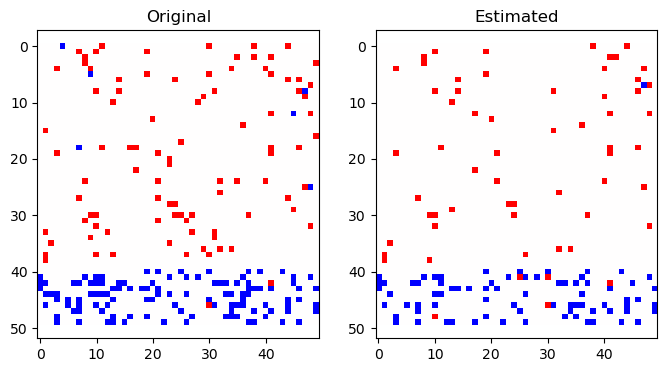

In [8]:
P = Pcausal_exc+Pcausal_inh

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(connect, cmap='bwr', aspect='auto')
plt.axis('equal')
plt.title('Original')
plt.subplot(122)
plt.imshow(P, cmap='bwr', aspect='auto')
plt.axis('equal')
plt.title('Estimated')
plt.show()

In [9]:
len(connect[connect>0]), len(Pcausal_exc[Pcausal_exc>0]), len(connect[connect<0]), len(Pcausal_inh[Pcausal_inh<0])

(94, 66, 118, 82)

### Mismatch in inhibitory connections

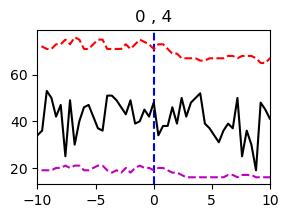

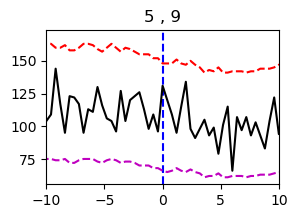

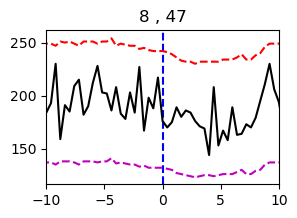

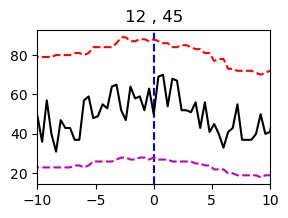

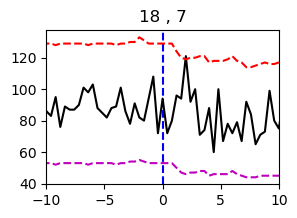

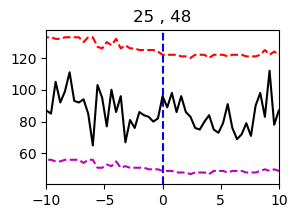

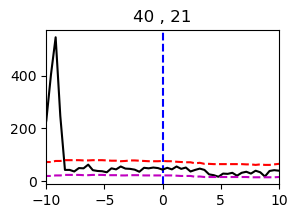

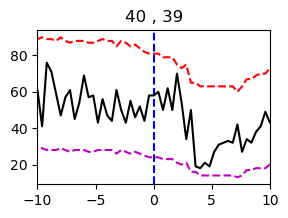

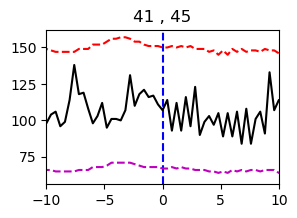

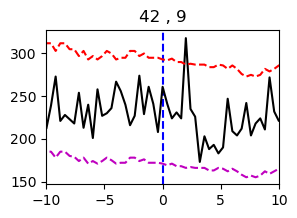

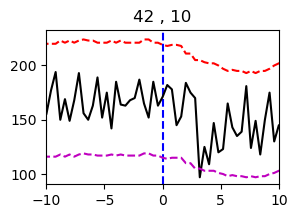

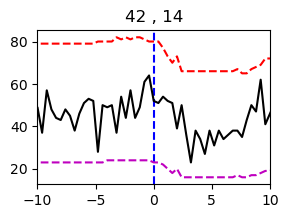

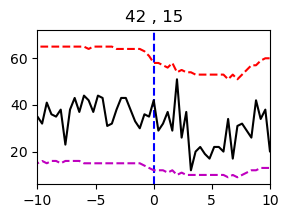

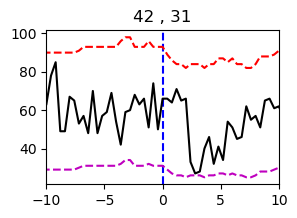

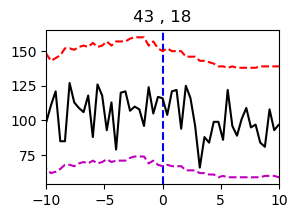

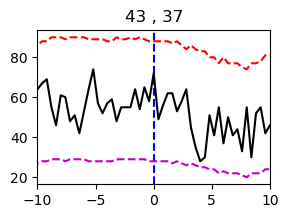

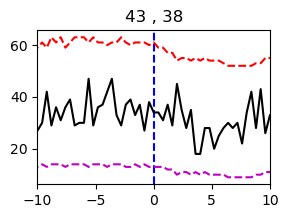

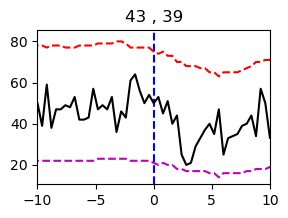

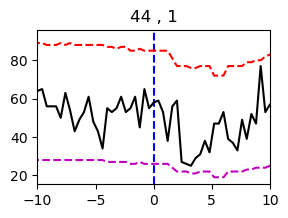

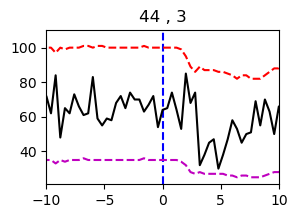

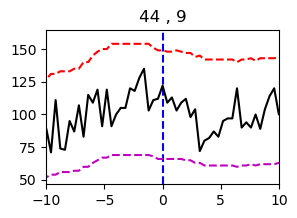

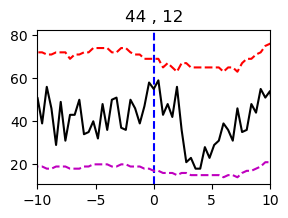

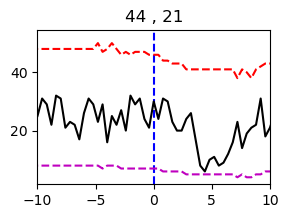

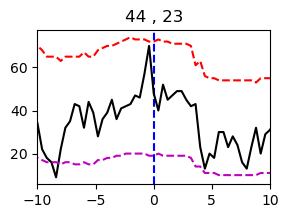

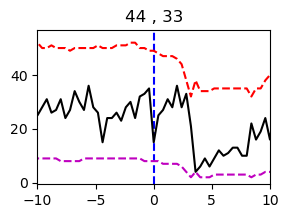

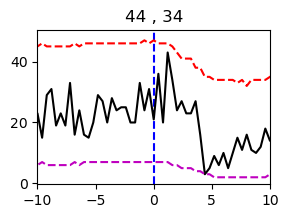

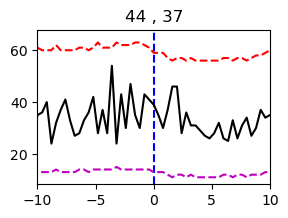

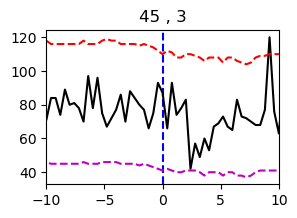

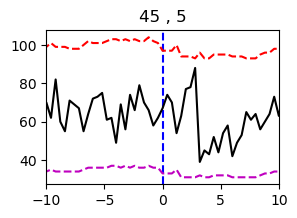

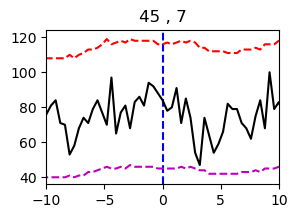

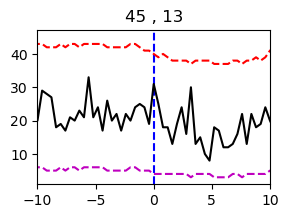

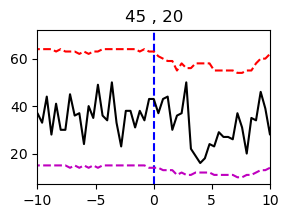

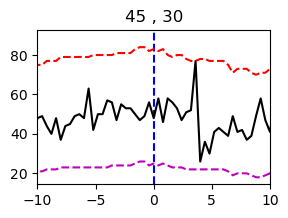

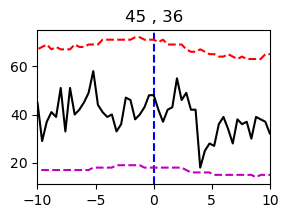

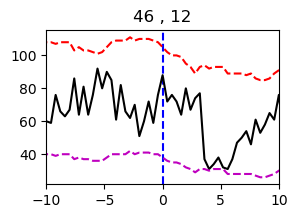

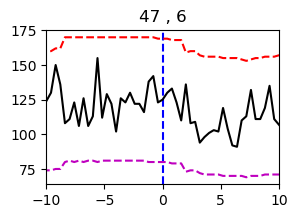

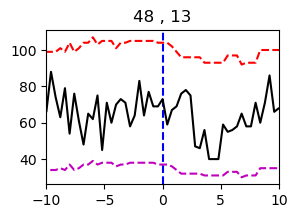

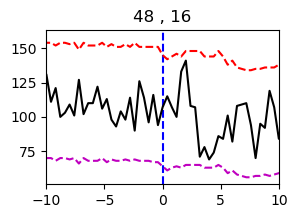

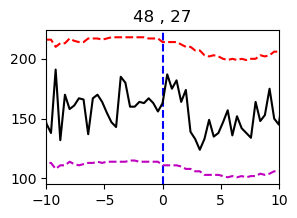

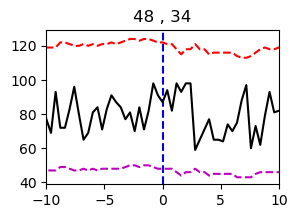

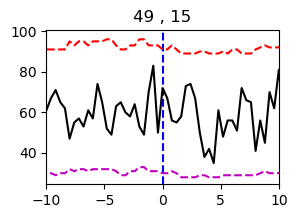

In [10]:
# Check these: [42,31], [43,46], [44,12], [44,21], [48,16], 
# [48,40] [47,11], [48,3], [48,40]
row, col = np.where((connect==-1) & (Pcausal_inh!=-1)) 
for r,c in zip(row,col): 
    plt.figure(figsize=(3,2)) 
    plt.axvline(x=0, c='b', ls='--')
    plt.plot(t*1000, cch[:, r, c], 'k') 
    plt.plot(t*1000, Bounds[:,r,c,0], 'r--') 
    plt.plot(t*1000, Bounds[:,r,c,1], 'm--')
    plt.title(str(r)+' , '+str(c)) 
    plt.xlim([-10,10]) 
    plt.show()

[]
True True True True False
True False True True False


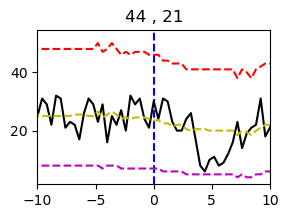

In [11]:
r,c = 44,21

ccg = cch[:,r,c]
# calculate null-distribution using convolution based 
# on Stark & Abeles; poisson continuity correction
pvals, pred, qvals = cch_conv(ccg, W, WINTYPE=convType)
pvals, pred, qvals = np.ravel(pvals), np.ravel(pred), np.ravel(qvals)
# calculate upper and lower bound with bonferroni correction, given alpha levels
hiBound, loBound = calculate_bounds(pred, alpha, np.ceil(win_monosyn/bin_dur)*2)

# 1) there should be a dip in 0.0008 ms - 0.0048 ms
dip_post = sig[postbins]
dip_pre = sig[prebins]

# 2) dip p-value < alpha (0.001)
dip_pval_check_post = qvals[postbins] < alpha
dip_pval_check_pre = qvals[prebins] < alpha

# 3) dip amp < 1.5 sd
dip_ht_post = np.nanmin(baseline_ccg[postbins])
dip_ht_pre = np.nanmin(baseline_ccg[prebins])
dipstd_check_post = dip_ht_post < dipsd*std_baseline
dipstd_check_pre = dip_ht_pre < dipsd*std_baseline

# 4) Dip’s width (contiguous bins with pvals < 0.01 or 0.5*peak_ht) in (0.8 - 4) ms
sig_bins = ((qvals[postbins]<alpha2) & ((baseline_ccg[postbins]<0.5*dip_ht_post) | (baseline_ccg[postbins]<-widthsd*std_baseline))).astype(int)
contiguous_segments = np.split(sig_bins, np.where(np.diff(sig_bins) != 0)[0] + 1)
widths_post = [len(seg)*bin_dur for seg in contiguous_segments if seg[0] == 1]
width_check_post = any(sig_width[0] <= width <= sig_width[-1] for width in widths_post)
print(widths_post)

sig_bins = ((qvals[prebins]<alpha2) & ((baseline_ccg[prebins]<0.5*dip_ht_pre) | (baseline_ccg[prebins]<-widthsd*std_baseline))).astype(int)
contiguous_segments = np.split(sig_bins, np.where(np.diff(sig_bins) != 0)[0] + 1)
widths_pre = [len(seg)*bin_dur for seg in contiguous_segments if seg[0] == 1]
width_check_pre = any(sig_width[0] <= width <= sig_width[-1] for width in widths_pre)

# 5) Peak’s width did not overlap with zero-lag bin (indicative of common input)
# modified to bring the range (-0.0004 - 0.0004)
no_overlap = np.any(~sig[zero_lag_bins])
if not no_overlap:
    zero_dip = np.nanmin(ccg[zero_lag_bins])
    if (np.nanmin(ccg[postbins]) < zero_dip) or (np.nanmin(ccg[prebins]) > zero_dip):
        no_overlap = False 
else:
    zero_dip = np.nanmin(ccg[zero_lag_bins])
    if zero_dip<np.nanmin(ccg[postbins]) and zero_dip<np.nanmin(ccg[prebins]):
        no_overlap = False

# check all condition
print(np.any(dip_post), np.any(dip_pval_check_post), no_overlap, dipstd_check_post, width_check_post)
print(np.any(dip_pre), np.any(dip_pval_check_pre), no_overlap, dipstd_check_pre, width_check_pre)


plt.figure(figsize=(3,2)) 
plt.axvline(x=0, c='b', ls='--')
plt.plot(t*1000, cch[:, r, c], 'k') 
plt.plot(t*1000, Bounds[:,r,c, 0], 'r--') 
plt.plot(t*1000, Bounds[:,r,c, 1], 'm--') 
plt.plot(t*1000, Pred[:,r,c], 'y--') 
plt.title(str(r)+' , '+str(c)) 
plt.xlim([-10,10]) 
plt.show()

### Mismatch in excitatory connections

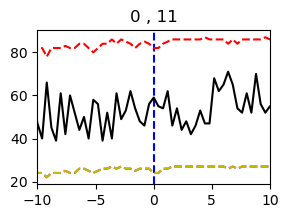

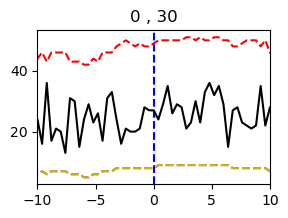

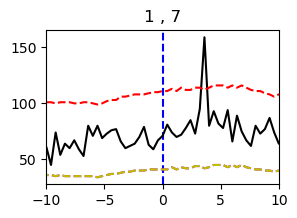

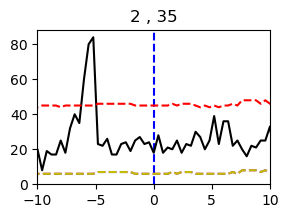

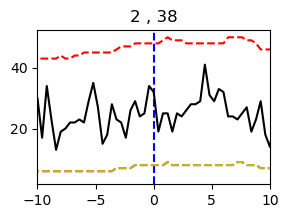

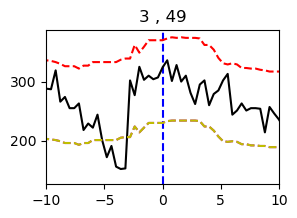

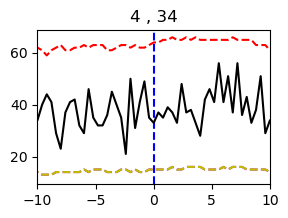

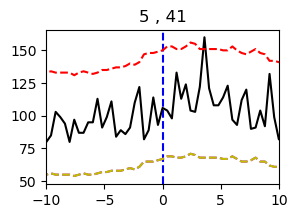

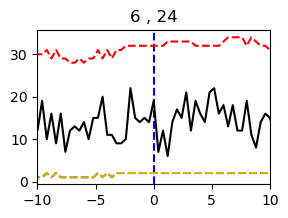

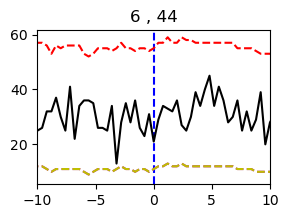

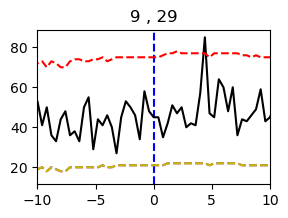

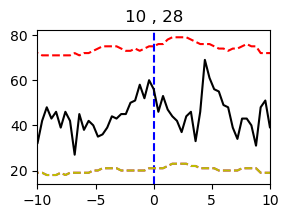

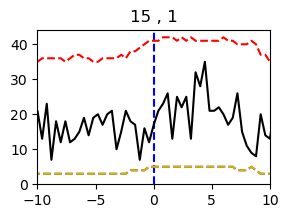

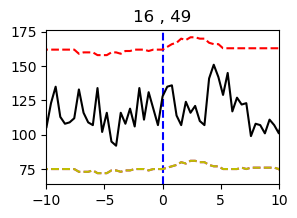

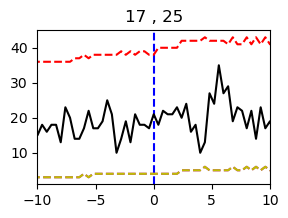

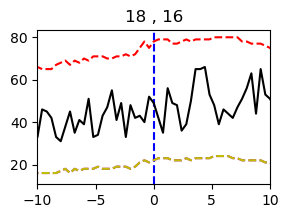

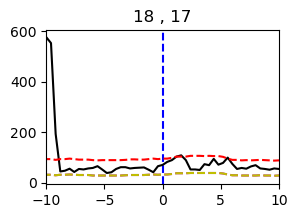

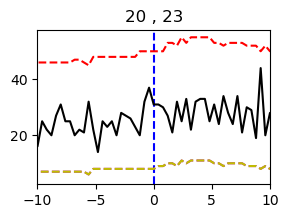

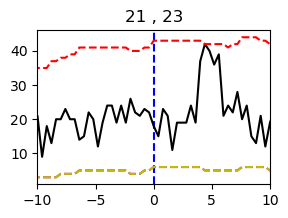

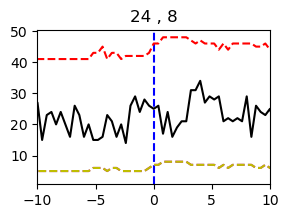

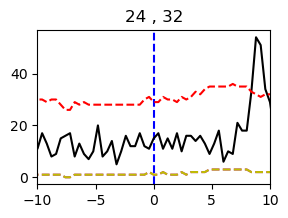

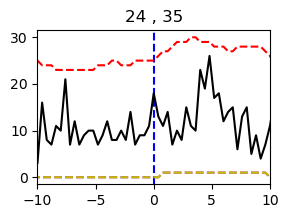

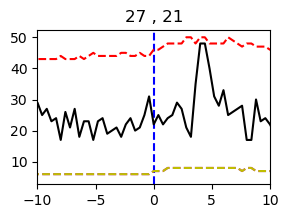

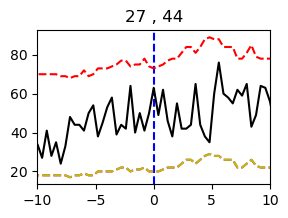

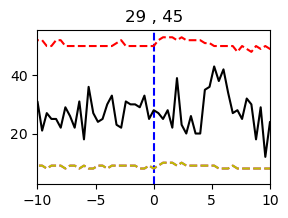

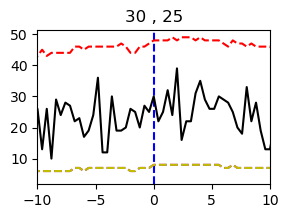

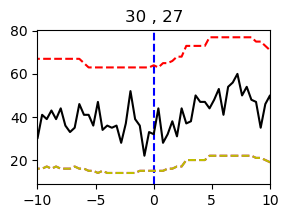

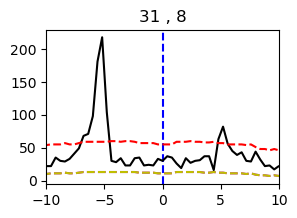

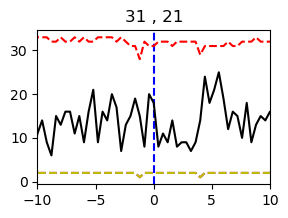

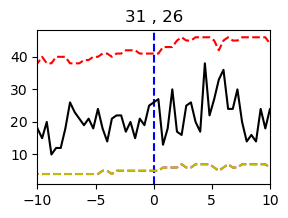

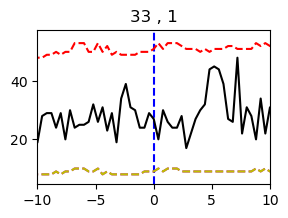

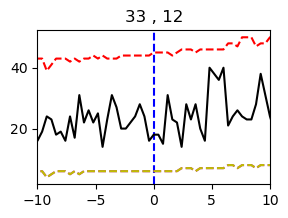

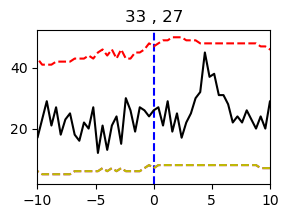

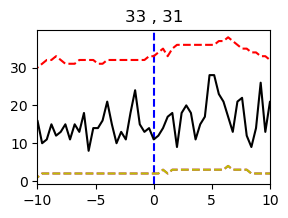

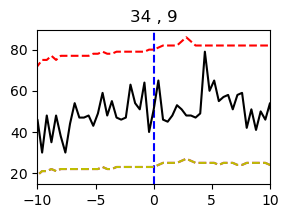

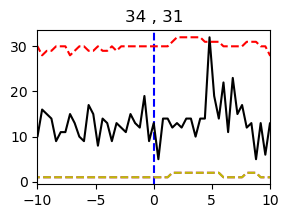

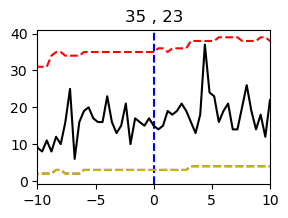

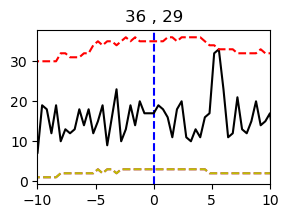

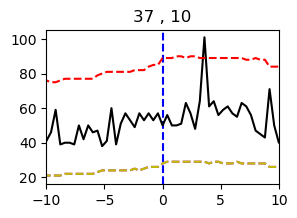

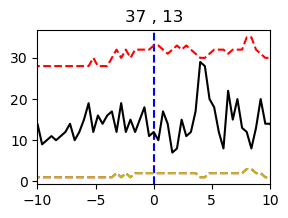

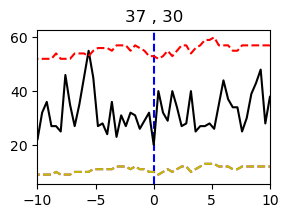

In [12]:
row, col = np.where((connect==1) & (Pcausal_exc!=1)) 
for r,c in zip(row,col): 
    plt.figure(figsize=(3,2)) 
    plt.axvline(x=0, c='b', ls='--')
    plt.plot(t*1000, cch[:, r, c], 'k') 
    plt.plot(t*1000, Bounds[:,r,c, 0], 'r--') 
    plt.plot(t*1000, Bounds[:,r,c, 1], 'm--') 
    plt.plot(t*1000, Bounds[:,r,c, 1], 'y--') 
    plt.title(str(r)+' , '+str(c)) 
    plt.xlim([-10,10]) 
    plt.show()

[0.0024000000000000002]
True True True True True
False False True True False


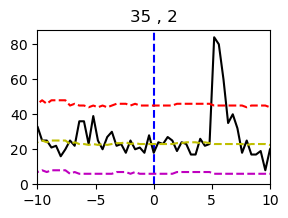

In [16]:
r,c = 35,2

ccg = cch[:,r,c]
# calculate null-distribution using convolution based 
# on Stark & Abeles; poisson continuity correction
pvals, pred, qvals = cch_conv(ccg, W, WINTYPE=convType)
pvals, pred, qvals = np.ravel(pvals), np.ravel(pred), np.ravel(qvals)
# calculate upper and lower bound with bonferroni correction, given alpha levels
hiBound, loBound = calculate_bounds(pred, alpha, np.ceil(win_monosyn/bin_dur)*2)

# check for significane for excitatory connections
sig = ccg > hiBound
baseline_ccg = ccg - pred
std_baseline = np.nanstd(baseline_ccg)

# 1) there should be a peak in 0.0008 ms - 0.0048 ms
peak_post = sig[postbins]
peak_pre = sig[prebins]

# 2) peak p-value < alpha (0.001)
peak_pval_check_post = pvals[postbins] < alpha
peak_pval_check_pre = pvals[prebins] < alpha

# 3) peak height > 2.5 sd
peak_ht_post = np.nanmax(baseline_ccg[postbins])
peak_ht_pre = np.nanmax(baseline_ccg[prebins])
peakstd_check_post = peak_ht_post > peaksd*std_baseline
peakstd_check_pre = peak_ht_pre > peaksd*std_baseline

# 4) Peak’s width (contiguous bins with pvals < 0.01 or 0.5*peak_ht) in (0.8 - 4) ms
sig_bins = ((pvals[postbins]<0.05) & ((baseline_ccg[postbins]>0.5*peak_ht_post) | (baseline_ccg[postbins]>0.5*std_baseline))).astype(int)
contiguous_segments = np.split(sig_bins, np.where(np.diff(sig_bins) != 0)[0] + 1)
widths_post = [len(seg)*bin_dur for seg in contiguous_segments if seg[0] == 1]
width_check_post = any(sig_width[0] <= width <= sig_width[-1] for width in widths_post)
print(widths_post)

sig_bins = ((pvals[prebins]<alpha2) & ((baseline_ccg[prebins]>0.5*peak_ht_pre) | (baseline_ccg[prebins]>widthsd*std_baseline))).astype(int)
contiguous_segments = np.split(sig_bins, np.where(np.diff(sig_bins) != 0)[0] + 1)
widths_pre = [len(seg)*bin_dur for seg in contiguous_segments if seg[0] == 1]
width_check_pre = any(sig_width[0] <= width <= sig_width[-1] for width in widths_pre)

# 5) Peak’s width did not overlap with zero-lag bin (indicative of common input)
# modified to bring the range (-0.0004 - 0.0004)
no_overlap = np.any(~sig[zero_lag_bins])
if not no_overlap:
    zero_peak = np.nanmax(ccg[zero_lag_bins])
    if np.nanmax(ccg[postbins])>zero_peak or np.nanmax(ccg[prebins])>zero_peak:
        no_overlap = False 
# else: 
#     zero_peak = np.nanmax(ccg[zero_lag_bins])
#     if zero_peak>np.nanmax(ccg[postbins]) and zero_peak>np.nanmax(ccg[prebins]):
#         no_overlap = False

# check all condition
print(np.any(peak_post), np.any(peak_pval_check_post), width_check_post, no_overlap, peakstd_check_post)
print(np.any(peak_pre), np.any(peak_pval_check_pre), width_check_pre, no_overlap, peakstd_check_pre)


plt.figure(figsize=(3,2)) 
plt.axvline(x=0, c='b', ls='--')
plt.plot(t*1000, cch[:, r, c], 'k') 
plt.plot(t*1000, Bounds[:,r,c, 0], 'r--') 
plt.plot(t*1000, Bounds[:,r,c, 1], 'm--') 
plt.plot(t*1000, Pred[:,r,c], 'y--') 
plt.title(str(r)+' , '+str(c)) 
plt.xlim([-10,10]) 
plt.show()

In [14]:
# o/p variables 
Pval = np.full([len(t), nCells, nCells], np.nan)
Pred = np.full([len(t), nCells, nCells], np.nan)
Bounds = np.full([cch.shape[0], nCells, nCells, 2], np.nan)
Pcausal_exc = np.zeros([nCells, nCells])
Pcausal_inh = np.zeros([nCells, nCells])
syn_strength_exc = np.full([nCells, nCells], np.nan)
syn_ratio_exc = np.full([nCells, nCells], np.nan)
syn_strength_inh = np.full((nCells, nCells), np.nan)
syn_ratio_inh = np.full((nCells, nCells), np.nan)
sig_con_exc = []
sig_con_inh = []

# post and pre bins to mess with
# some sig. digit shit to deal with
postbins = (t>=min_win_monosyn) & (t<=win_monosyn+bin_dur/2)
prebins = (t<=-min_win_monosyn) & (t>=-win_monosyn-bin_dur/2)
zero_lag_bins = (t>=zero_bins[0]-bin_dur/2) & (t<=zero_bins[1]+bin_dur/2)

# go through each pair 
for refcid in range(nCells):
    for targetcid in range(refcid+1, nCells):
        # ccg for respective connection
        ccg = cch[:, refcid, targetcid]

        # calculate null-distribution using convolution based 
        # on Stark & Abeles; poisson continuity correction
        pvals, pred, qvals = cch_conv(ccg, W, WINTYPE=convType)
        pvals, pred, qvals = np.ravel(pvals), np.ravel(pred), np.ravel(qvals)
        # Store predicted values and pvalues for subsequent plotting
        Pred[:, refcid, targetcid] = pred
        Pval[:, refcid, targetcid] = pvals
        Pred[:, targetcid, refcid] = np.flipud(pred)
        Pval[:, targetcid, refcid] = np.flipud(pvals)
        
        # calculate upper and lower bound with bonferroni correction, given alpha levels
        hiBound, loBound = calculate_bounds(pred, alpha, np.ceil(win_monosyn/bin_dur)*2)
        Bounds[:, refcid, targetcid, 0] = hiBound
        Bounds[:, refcid, targetcid, 1] = loBound
        Bounds[:, targetcid, refcid, 0] = np.flipud(hiBound)
        Bounds[:, targetcid, refcid, 1] = np.flipud(loBound)

        ########## EXCITATORY checks for both sides ref -> target (post), target -> ref (pre)
        sig = ccg > hiBound
        baseline_ccg = ccg - pred
        std_baseline = np.nanstd(baseline_ccg)
        
        # check all condition
        # peak pval < 0.001, peak > 2.5 sd, in [0.8 - 4.8]ms
        # width pval < 0.01, width > 1 sd or 1/2*height of peak
        # no zero lag peaks (common input)
        post_exc_check, pre_exc_check = check_exc_conn(ccg, hiBound, loBound, pred, pvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur,
                                                       alpha=alpha, alpha2=alpha2, sig_width=sig_width, peaksd=peaksd, widthsd=widthsd)

        # store o/p
        if post_exc_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[postbins]
            bccg[bccg<0] = 0
            syn_strength_exc[refcid,targetcid] = np.nansum(bccg)/Nspk[refcid]
            # peak/baseline ratio
            syn_ratio_exc[refcid, targetcid] = np.nanmax(ccg[postbins])/np.nanmean(pred[postbins])
            sig_con_exc.append([refcid, targetcid])
            Pcausal_exc[refcid, targetcid] = 1

        if pre_exc_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[prebins]
            bccg[bccg<0] = 0
            syn_strength_exc[targetcid, refcid] = np.nansum(bccg)/Nspk[targetcid]
            # peak/baseline ratio
            syn_ratio_exc[targetcid, refcid] = np.nanmax(ccg[prebins])/np.nanmean(pred[prebins])
            sig_con_exc.append([targetcid, refcid])
            Pcausal_exc[targetcid, refcid] = 1
            
        #print(refcid, targetcid, post_exc_check, pre_exc_check)

        ######### INHIBITORY connections checks again for both directions
        post_inh_check, pre_inh_check = check_inh_conn(ccg, hiBound, loBound, pred, qvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur, 
                                                       alpha=alpha, alpha2=alpha2, sig_width=sig_width, dipsd=dipsd, widthsd=widthsd)
    
        # remove if excitatory connections detected
        if post_exc_check:
            post_inh_check = False
        if pre_exc_check:
            pre_inh_check = False

        # store o/p
        if post_inh_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[postbins]
            bccg[bccg>0] = 0
            syn_strength_inh[refcid,targetcid] = np.abs(np.nansum(bccg))/Nspk[refcid]
            # valley/baseline ratio
            syn_ratio_inh[refcid, targetcid] = np.abs(np.nanmin(ccg[postbins])/np.nanmean(pred[postbins]))
            sig_con_inh.append([refcid, targetcid])
            Pcausal_inh[refcid, targetcid] = -1

        if pre_inh_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[prebins]
            bccg[bccg>0] = 0
            syn_strength_inh[targetcid, refcid] = np.abs(np.nansum(bccg)/Nspk[targetcid])
            # valley/baseline ratio
            syn_ratio_inh[targetcid, refcid] = np.abs(np.nanmin(ccg[prebins])/np.nanmean(pred[prebins]))
            sig_con_inh.append([targetcid, refcid])
            Pcausal_inh[targetcid, refcid] = -1

        #print(refcid, targetcid, post_inh_check, pre_inh_check)

NameError: name 'null_ci_alpha' is not defined

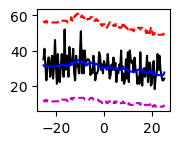

In [15]:
# plot CCG with significance bounds
count = 1 
plt.figure(figsize=(12,30))
for refcid in range(nCells):
    for targetcid in range(refcid+1,nCells):
        plt.subplot(19,6,count)
        plt.plot(t*1000, cch[:,refcid,targetcid], c='k')
        plt.plot(t*1000, Pred[:,refcid,targetcid], c='b')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,0], 'r--')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,1], 'm--')
        plt.plot(t*1000, null_ci_alpha[0,:,targetcid*len(Nspk)+refcid], color='r', ls='--', alpha=0.5)
        plt.plot(t*1000, null_ci_alpha[2,:,targetcid*len(Nspk)+refcid], color='g', ls='--', alpha=0.5)
        plt.xlim([-10,10])
        plt.yticks([])
        plt.title(str(refcid)+','+str(targetcid))
        count = count+1
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(Pcausal_exc, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.title('Conn matrix - Exc')
plt.axis('equal')
plt.subplot(232)
plt.imshow(syn_strength_exc, aspect='auto')
plt.title('Excess transmission')
plt.axis('equal')
plt.subplot(233)
plt.imshow(syn_ratio_exc, aspect='auto')
plt.title('Peak/Baseline ratio')
plt.axis('equal')
plt.subplot(234)
plt.imshow(Pcausal_inh, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.axis('equal')
plt.title('Conn matrix - Inh')
plt.subplot(235)
plt.imshow(syn_strength_inh, aspect='auto')
plt.axis('equal')
plt.title('Excess inhibition')
plt.subplot(236)
plt.imshow(syn_ratio_inh, aspect='auto')
plt.axis('equal')
plt.title('Valley/Baseline ratio')
plt.show()